In [1]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

# Loading Data

In [2]:
f = open('Sample Transcription.txt')

In [3]:
string_file = f.read()

In [4]:
transcriptions = re.findall(r'Transcription: (.*?), cabin', string_file)

In [5]:
time_stamps = re.findall(r'20(.*?) -', string_file)

In [6]:
df = pd.DataFrame(list(zip(time_stamps, transcriptions)),
               columns =['Time', 'Transcriptions'])

In [7]:
df.head()

,Time,Transcriptions
0,21-10-02 22:01:44.143,03 VISUAL APPROACH 18 RIGHT
1,21-10-02 22:01:51.324,AMERICAN 470 TURN RIGHT HEADING 090 DESCEND AN...
2,21-10-02 22:01:52.885,09013
3,21-10-02 22:02:02.232,AMERICAN 377 MAINTAIN 170 KNOTS TO LINDY CONTA...
4,21-10-02 22:02:04.833,170


In [8]:
df.describe()

,Time,Transcriptions
count,425,425
unique,425,400
top,21-10-02 22:49:54.617,4000
freq,1,5


# Processing Data

In [9]:
df['Length'] = df['Transcriptions'].apply(len)
df.head()

,Time,Transcriptions,Length
0,21-10-02 22:01:44.143,03 VISUAL APPROACH 18 RIGHT,27
1,21-10-02 22:01:51.324,AMERICAN 470 TURN RIGHT HEADING 090 DESCEND AN...,61
2,21-10-02 22:01:52.885,09013,5
3,21-10-02 22:02:02.232,AMERICAN 377 MAINTAIN 170 KNOTS TO LINDY CONTA...,69
4,21-10-02 22:02:04.833,170,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A9475F1BC8>]],
      dtype=object)

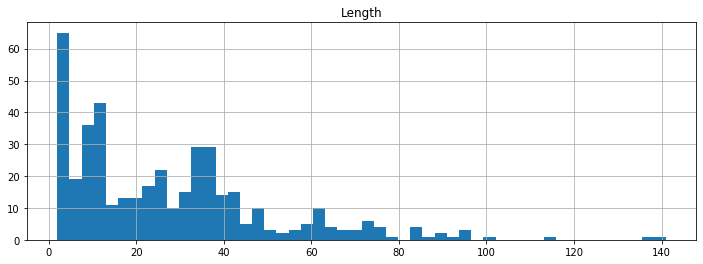

In [10]:
df.hist(column='Length', bins=50,figsize=(12,4))

This makes sense since many readbacks are barely detected, resulting in abnormally short responses. What this analysis thus must focus on is the controllers' commands.

# Analyzing Key Words

Words to know:
* Descend / Ascend
* Turn / Heading
* Contact / Tower
* Speed
* Clear / Cleared

In [11]:
processed_df = df.copy()

In [12]:
processed_df = processed_df[processed_df['Length'] > 15]

In [13]:
### The following functions will be used to look for keywords

def find_alt(command):
    command = str.lower(command)
    return ('descend' in command) or ('ascend' in command) or ('climb' in command) or ('altitude' in command)

def find_turn(command):
    command = str.lower(command)
    return ('turn' in command) or ('heading' in command) or ('left' in command) or ('right' in command)

def find_contact(command):
    command = str.lower(command)
    return ('contact' in command) or ('tower' in command) or ('radio' in command) or ('up' in command) or ('climb' in command)

def find_speed(command):
    command = str.lower(command)
    return ('speed' in command) or ('reduce' in command) or ('slow' in command) or ('knots' in command)

def find_clearance(command):
    command = str.lower(command)
    return ('clear' in command)

In [14]:
processed_df['altitude'] = processed_df['Transcriptions'].apply(find_alt)
processed_df['turn'] = processed_df['Transcriptions'].apply(find_turn)
processed_df['contact'] = processed_df['Transcriptions'].apply(find_contact)
processed_df['speed'] = processed_df['Transcriptions'].apply(find_speed)
processed_df['clearance'] = processed_df['Transcriptions'].apply(find_clearance)

The code above created new colums, each representing the whether a command pertains to each of the five categories listed above. 

Up next, we'll be locating callsigns. Because callsigns are said differently (and interpereted differently), this must be robust in the future.
TODO: scrape the following to create more comprehensive list - https://en.wikipedia.org/wiki/List_of_airline_codes

In [15]:
### The following looks for callsigns.
known_callsign_prefixes = ['american', 'envoy', 'biztex', 'frontier', 'skywest', 'sioux', 'cessna', 'grumman', 'speedbird']

def find_callsign(command):
    command = str.lower(command)
    prefix = set(str.split(command, " ")).intersection(set(known_callsign_prefixes))
    if prefix:
        prefix = prefix.pop()
        command_list = str.split(command)
        suffix_loc = [i for i, x in enumerate(command_list) if x==prefix]
        suffix = command_list[suffix_loc[0]+1]
        return prefix + suffix
    return False

In [16]:
processed_df['Callsign'] = processed_df['Transcriptions'].apply(find_callsign)

In [17]:
processed_df.head()

,Time,Transcriptions,Length,altitude,turn,contact,speed,clearance,Callsign
0,21-10-02 22:01:44.143,03 VISUAL APPROACH 18 RIGHT,27,False,True,False,False,False,False
1,21-10-02 22:01:51.324,AMERICAN 470 TURN RIGHT HEADING 090 DESCEND AN...,61,True,True,False,False,False,american470
3,21-10-02 22:02:02.232,AMERICAN 377 MAINTAIN 170 KNOTS TO LINDY CONTA...,69,False,False,True,True,False,american377
5,21-10-02 22:02:33.535,AMERICAN 14 03 DESCEND AND MAINTAIN 4000,40,True,False,False,False,False,american14
6,21-10-02 22:02:35.479,DESCEND AND MAINTAIN 4000 AMERICAN 14,37,True,False,False,False,False,american14


In [31]:
print(processed_df['altitude'].value_counts())
print(processed_df['turn'].value_counts())
print(processed_df['contact'].value_counts())
print(processed_df['speed'].value_counts())
print(processed_df['clearance'].value_counts())

False    188
True      63
Name: altitude, dtype: int64
False    162
True      89
Name: turn, dtype: int64
False    218
True      33
Name: contact, dtype: int64
False    210
True      41
Name: speed, dtype: int64
False    222
True      29
Name: clearance, dtype: int64


In [34]:
processed_df.to_csv('processed_df.csv')

to-do
* Find callsign
* Implement ways to reliably find the subtext (eg. specific speed / altitude)

# Bag of Words Stuff

In [24]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'to', 'from',
'in', 'out', 'on', 'off', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'ah']

In [ ]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Transcriptions'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

TypeError: 'NoneType' object is not iterable

In [ ]:
# Sample Data Point
message4 = df['Transcriptions'][3]
print(message4)

AMERICAN 377 MAINTAIN 170 KNOTS TO LINDY CONTACT THE TOWER NOW 124.15


In [ ]:
# Sample Data Point in Bow Transform Form
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 32)	1
  (0, 61)	1
  (0, 132)	1
  (0, 229)	1
  (0, 252)	1
  (0, 304)	1
  (0, 307)	1
  (0, 313)	1
  (0, 359)	1
(1, 380)


In [ ]:
# Applying transformation to the entire data set
messages_bow = bow_transformer.transform(df['Transcriptions'])

In [ ]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (425, 380)
Amount of Non-Zero occurences:  1883
